In [2]:
# %% === < Global Setting: Time and Seed > ===
import time
import numpy as np
local_time = time.strftime("%Y%m%d_%H%M", time.localtime())
print("Time:", local_time)
seed = int(round(1000000*np.random.random()))
print("Seed:", seed)
np.random.seed(seed)

Time: 20210330_1830
Seed: 166989


In [3]:
# %% === < Images importing > ===
import os
import tensorflow as tf
from keras.preprocessing import image_dataset_from_directory
image_size = (224, 224)
image_shape = image_size + (3,)
batch_size = 128
DataFolder = './food101/images'
num_category = len(os.listdir(DataFolder))
print('Number of category: %d' % num_category)
TrainingDataset = image_dataset_from_directory(DataFolder, 
    labels='inferred',
    validation_split=0.3,
    subset='training',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
    )
ValidationDataset = image_dataset_from_directory(DataFolder, 
    labels='inferred',
    validation_split=0.3,
    subset='validation',
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
    )

Number of category: 101
Found 101000 files belonging to 101 classes.
Using 70700 files for training.
Found 101000 files belonging to 101 classes.
Using 30300 files for validation.


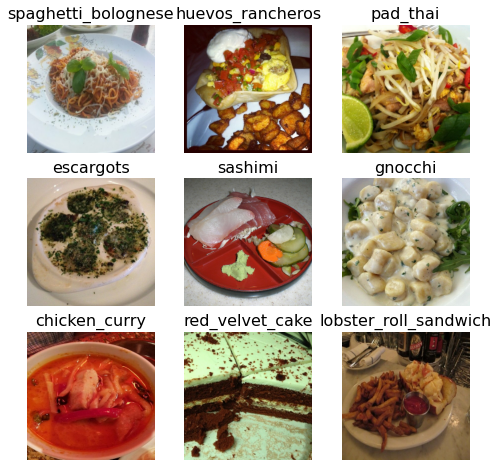

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
class_names = TrainingDataset.class_names
plt.figure(figsize=(8,8))
for images, labels in TrainingDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.savefig('./result/food101_example_%s.png'%local_time, dpi=300)

In [5]:
ValidationBatches = tf.data.experimental.cardinality(ValidationDataset)
TestingDataset = ValidationDataset.take(ValidationBatches // 5)
ValidationDataset = ValidationDataset.skip(ValidationBatches // 5)

In [6]:
TrainingBatches = tf.data.experimental.cardinality(TrainingDataset)
ValidationBatches = tf.data.experimental.cardinality(ValidationDataset)
TestingBatches = tf.data.experimental.cardinality(TestingDataset)
print('Number of training batches: %d' % TrainingBatches)
print('Number of validation batches: %d' % ValidationBatches)
print('Number of testing batches: %d' % TestingBatches)

Number of training batches: 553
Number of validation batches: 190
Number of testing batches: 47


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
print(AUTOTUNE)

-1


In [8]:
TrainingDataset = TrainingDataset.prefetch(buffer_size=AUTOTUNE)
ValidationDataset = ValidationDataset.prefetch(buffer_size=AUTOTUNE)
TestingDataset = ValidationDataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# AugmentationDataset = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1))
#     ])

In [ ]:
# for image, _ in TrainingDataset.take(1):
#     plt.figure(figsize=(8,8))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         AugmentedImage = AugmentationDataset(tf.expand_dims(first_image, 0))
#         plt.imshow(AugmentedImage[0] / 255)
#         plt.axis('off')

In [9]:
# %% === < Checking pretrained model > ===
from keras.applications.resnet50 import ResNet50
model_pretrained = ResNet50(include_top=True)
#model_pretrained.summary()

In [ ]:
# %% === < Importing pretrained model with custom input shape > ===
# from keras.applications.resnet50 import ResNet50
# input_shape_custom = (512, 512, 3)
# model_pretrained = ResNet50(include_top=False, input_shape=input_shape_custom)
# model_pretrained.summary()

In [10]:
model_pretrained.trainable = False

In [11]:
from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential([
    preprocessing.RandomFlip('horizontal',input_shape=image_shape),
#     preprocessing.RandomRotation(0.1),
    preprocessing.RandomTranslation(height_factor=(-0.1,0.1),width_factor=(-0.1,0.1)),
    model_pretrained,
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(num_category, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 101)               4

In [12]:
from keras.optimizers import Adam
model.compile(loss = 'sparse_categorical_crossentropy', 
  optimizer = Adam(lr = 0.001), 
  metrics = ['accuracy']
  )
initial_epochs = 10
loss0, accuracy0 = model.evaluate(ValidationDataset)
print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

190/190 [==============================] - 80s 283ms/step - loss: 4.6153 - accuracy: 0.0107
Initial loss: 4.62
Initial accuracy: 0.01
Epoch 1/10
553/553 [==============================] - 230s 402ms/step - loss: 3.8562 - accuracy: 0.1266 - val_loss: 3.5126 - val_accuracy: 0.1805
Epoch 2/10
553/553 [==============================] - 228s 409ms/step - loss: 3.4199 - accuracy: 0.1959 - val_loss: 3.3376 - val_accuracy: 0.2172
Epoch 3/10
553/553 [==============================] - 228s 408ms/step - loss: 3.2326 - accuracy: 0.2299 - val_loss: 3.2473 - val_accuracy: 0.2358
Epoch 4/10
553/553 [==============================] - 228s 410ms/step - loss: 3.1053 - accuracy: 0.2518 - val_loss: 3.1510 - val_accuracy: 0.2485
Epoch 5/10
553/553 [==============================] - 227s 408ms/step - loss: 2.9997 - accuracy: 0.2721 - val_loss: 3.1269 - val_accuracy: 0.2581
Epoch 6/10
553/553 [==============================] - 227s 406ms/step - loss: 2.9109 - accuracy: 0.2875 - val_loss: 3.0997 - val_accurac

In [13]:
from keras.callbacks import EarlyStopping
patience = 5
callback = EarlyStopping(monitor = 'val_loss',
  mode = 'min', 
  patience = patience,
  verbose = 1
  )
history = model.fit(TrainingDataset,
  validation_data = ValidationDataset,
  epochs = initial_epochs,
  verbose = 1,
  callbacks = [callback]
  )

Epoch 1/10
553/553 [==============================] - 225s 403ms/step - loss: 2.5535 - accuracy: 0.3588 - val_loss: 3.0676 - val_accuracy: 0.2859
Epoch 2/10
553/553 [==============================] - 224s 402ms/step - loss: 2.4904 - accuracy: 0.3703 - val_loss: 3.0790 - val_accuracy: 0.2892
Epoch 3/10
553/553 [==============================] - 227s 408ms/step - loss: 2.4318 - accuracy: 0.3828 - val_loss: 3.1089 - val_accuracy: 0.2870
Epoch 4/10
553/553 [==============================] - 226s 406ms/step - loss: 2.3803 - accuracy: 0.3923 - val_loss: 3.1002 - val_accuracy: 0.2891
Epoch 5/10
553/553 [==============================] - 227s 408ms/step - loss: 2.3181 - accuracy: 0.4049 - val_loss: 3.1237 - val_accuracy: 0.2881
Epoch 6/10
553/553 [==============================] - 229s 411ms/step - loss: 2.2588 - accuracy: 0.4196 - val_loss: 3.1344 - val_accuracy: 0.2902
Epoch 00006: early stopping


In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

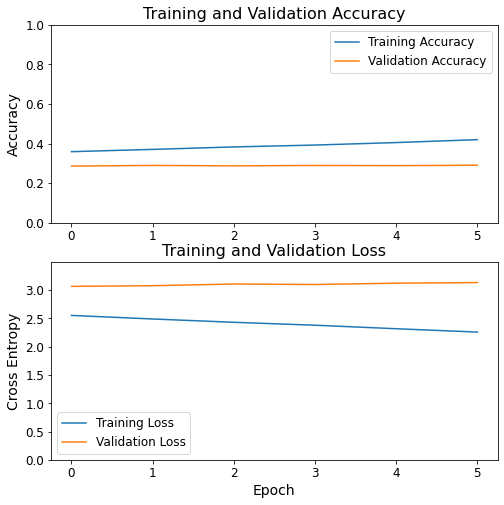

In [15]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0,1.1*max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig('./result/food101_history_pre_%s.png'%local_time, dpi=300)

In [16]:
model_pretrained.trainable = True

In [17]:
from keras.optimizers import Adam
model.compile(loss = 'sparse_categorical_crossentropy', 
  optimizer = Adam(learning_rate=0.001), 
  metrics = ['accuracy']
  )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              4100096   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_2 (Dense)              (None, 101)               4

In [18]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
fine_tune_1_epochs = 60
total_1_epochs =  initial_epochs + fine_tune_1_epochs
EarlyStop = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min', 
    patience = 10,
    verbose = 1
    )
LRSchedule = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 1, 
    verbose = 1
    )
history_fine_1 = model.fit(TrainingDataset,
                          validation_data=ValidationDataset,
                          epochs=total_1_epochs,
                          initial_epoch=history.epoch[-1],
                          verbose = 1,
                          callbacks = [EarlyStop, LRSchedule]
                          )

Epoch 6/70
553/553 [==============================] - 271s 466ms/step - loss: 3.1673 - accuracy: 0.2579 - val_loss: 5.5434 - val_accuracy: 0.0278
Epoch 7/70
553/553 [==============================] - 257s 462ms/step - loss: 2.1351 - accuracy: 0.4577 - val_loss: 2.1230 - val_accuracy: 0.4680
Epoch 8/70
553/553 [==============================] - 259s 465ms/step - loss: 1.9834 - accuracy: 0.4941 - val_loss: 2.5289 - val_accuracy: 0.4287

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/70
553/553 [==============================] - 258s 463ms/step - loss: 1.2396 - accuracy: 0.6652 - val_loss: 1.2744 - val_accuracy: 0.6710
Epoch 10/70
553/553 [==============================] - 260s 466ms/step - loss: 1.0467 - accuracy: 0.7146 - val_loss: 1.2415 - val_accuracy: 0.6785
Epoch 11/70
553/553 [==============================] - 259s 465ms/step - loss: 0.9632 - accuracy: 0.7358 - val_loss: 1.2359 - val_accuracy: 0.6825
Epoch 12/70
553/553 [===================

In [19]:
acc += history_fine_1.history['accuracy']
val_acc += history_fine_1.history['val_accuracy']

loss += history_fine_1.history['loss']
val_loss += history_fine_1.history['val_loss']

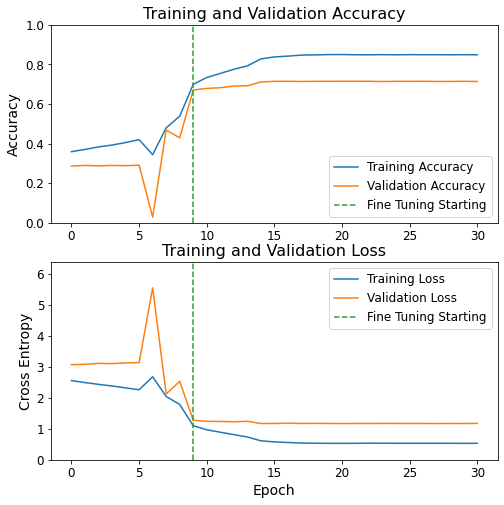

In [20]:
plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim([0,1]),'--', label='Fine Tuning Starting')
plt.ylim([0,1])
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim([0,1.1*max(plt.ylim())]),'--', label='Fine Tuning Starting')
plt.ylim([0,max(plt.ylim())])
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.savefig('./result/food101_history_%s.png'%local_time, dpi=300)

In [21]:
# --- saving weights and structure
model_h5_folder = 'result/model_weights/'
model_h5_file = 'food101_ResNet50_' + local_time + '.h5'
model.save(model_h5_folder + model_h5_file)  # creates a HDF5 file

In [22]:
list_loss = []
list_acc = []

loss, accuracy = model.evaluate(TrainingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Training loss: {:.4f}".format(loss))
print("Training accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(ValidationDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Validation loss: {:.4f}".format(loss))
print("Validation accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(TestingDataset)
list_loss.append(loss)
list_acc.append(accuracy)
print("Testing loss: {:.4f}".format(loss))
print("Testing accuracy: {:.4f}".format(accuracy))

with open('./result/food101_loss_%s.txt'%local_time, 'w') as f:
    for item in list_loss:
        f.write("%s\n" % item)
with open('./result/food101_acc_%s.txt'%local_time, 'w') as f:
    for item in list_acc:
        f.write("%s\n" % item)

553/553 [==============================] - 157s 280ms/step - loss: 0.5171 - accuracy: 0.8541
Training loss: 0.5171
Training accuracy: 0.8541
190/190 [==============================] - 69s 280ms/step - loss: 1.1677 - accuracy: 0.7146
Validation loss: 1.1677
Validation accuracy: 0.7146
190/190 [==============================] - 68s 278ms/step - loss: 1.1732 - accuracy: 0.7142
Testing loss: 1.1732
Testing accuracy: 0.7142


In [23]:
# pred_prop_training = model.predict(TrainingDataset)
# pred_prop_validation = model.predict(ValidationDataset)
# pred_prop_testing = model.predict(TestingDataset)
# # print(pred_prop_testing)

# pred_training = tf.argmax(pred_prop_training, axis=1)
# pred_validation = tf.argmax(pred_prop_validation, axis=1)
# pred_testing = tf.argmax(pred_prop_testing, axis=1)
# # print(pred_testing)

# true_training = tf.concat([y for x, y in TrainingDataset], axis=0)
# true_validation = tf.concat([y for x, y in ValidationDataset], axis=0)
# true_testing = tf.concat([y for x, y in TestingDataset], axis=0)
# # print(true_testing)

In [24]:
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns
# def info(true,pred):
#     # === Accuracy
#     print("Accuracy: %.4f"%accuracy_score(true,pred))
#     print(classification_report(true,pred))
#     # === Confusion Matrix
#     plt.figure()
#     sns.heatmap(confusion_matrix(true,pred,normalize=None), annot=True, cmap='YlGnBu')
#     # xticklabelstarget_names, yticklabels=target_names
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.title('Confusion Matrix')
#     plt.show()
#     # === Normalized Confusion Matrix
#     plt.figure()
#     sns.heatmap(confusion_matrix(true,pred,normalize='true'), annot=True, cmap='Blues', vmin=0, vmax=1)
#     # xticklabelstarget_names, yticklabels=target_names
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.title('Normalized Confusion Matrix')
#     plt.show()

In [25]:
# info(true_training,pred_training)

In [26]:
# info(true_validation,pred_validation)

In [27]:
# info(true_testing,pred_testing)

In [28]:
# %% === < Finish Time > ===
import time
print("Finish Time:", time.strftime("%Y%m%d_%H%M", time.localtime()))

Finish Time: 20210330_2333
